In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IncrementalTorch.datasets import Covertype, Shuttle
from river.datasets import CreditCard

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": ["Computer Modern Serif"],
    }
)
# for Palatino and other serif fonts use:
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
    }
)

colors = {
    "AE": "tab:blue",
    "DAE": "tab:cyan",
    "PW-AE": "tab:pink",
    "Kit-Net": "tab:red",
    "ExactStorm": "tab:purple",
    "xStream": "tab:brown",
    "HST": "tab:green",
}

markers = {
    "AE": "^",
    "DAE": "*",
    "PW-AE": "s",
    "Kit-Net": "D",
    "ExactStorm": "h",
    "xStream": "v",
    "HST": "o",
}


## Plot Capacity Experiment Results


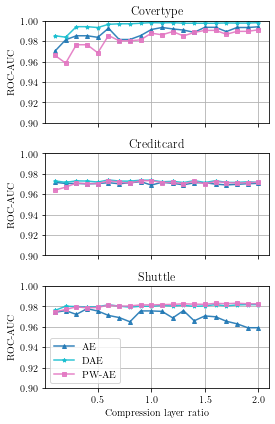

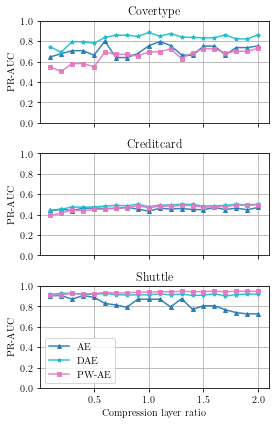

In [47]:
cap_data = pd.read_csv(
    "../results/Capacity.csv"
)

width=4
height=6
alpha=0.9

for metric in ["ROC-AUC", "PR-AUC"]:
    fig, axs = plt.subplots(nrows=3, figsize=(width, height), sharex=True, sharey=True)
    axs[2].set_xlabel("Compression layer ratio")
    if metric == "PR-AUC":
        axs[0].set_ylim(0, 1)
    else: 
        axs[0].set_ylim(0.9, 1)

    for idx, (dataset, res_dataset) in enumerate(cap_data.groupby("dataset")):
        axs[idx].set_ylabel(metric)
        axs[idx].set_title(dataset.capitalize())
        axs[idx].grid()
        for model_name, res_model in res_dataset.groupby("model"):
            axs[idx].plot(
                res_model.latent_dim,
                res_model[metric],
                marker=markers[model_name],
                c=colors[model_name],
                label=model_name,
                ms=4,
                alpha=alpha
            )

    axs[2].legend()
    plt.tight_layout()
    plt.savefig(f"../results/figures/{metric.lower()}_vs_compression.pdf")


## Plot Contamination Experiment Results


In [48]:
cont_data = pd.read_csv(
    "../results/Contamination.csv", index_col="anom_fraction"
)
cont_data.index *= 100
cont_data.sort_index(inplace=True)

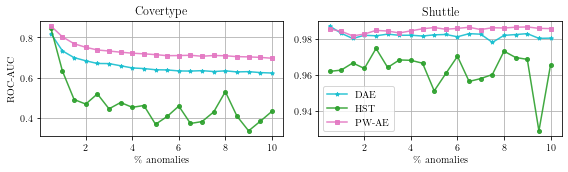

In [49]:
cont_data = cont_data[cont_data.dataset != "creditcard"]
ncols=cont_data.dataset.nunique()
width = 4*ncols
height = 2.5
alpha = 0.9

fig, axs = plt.subplots(ncols=ncols, figsize=(width, height), sharey=False)
axs[0].set_ylabel("ROC-AUC")
for idx, (dataset, dataset_data) in enumerate(cont_data.groupby("dataset")):
    
    axs[idx].set_title(dataset.capitalize())
    axs[idx].set_xlabel("\% anomalies")
    axs[idx].grid()
    for modelname, df_group in dataset_data.groupby("model"):
        axs[idx].plot(
            df_group.index,
            df_group["ROC-AUC"],
            label=modelname,
            marker=markers[modelname],
            c=colors[modelname],
            ms=4,
            alpha=alpha,
        )

axs[ncols-1].legend()
plt.tight_layout()
plt.savefig("../results/figures/roc-auc_vs_anom_frac.pdf")

## Plot anomaly score over data stream

In [56]:
from IncrementalTorch.datasets import Shuttle, Covertype
from river.datasets import CreditCard

DATASETS = {"creditcard": CreditCard, "covertype": Covertype, "shuttle": Shuttle}


def plot_scores(scores, labels, ax, model, alpha=0.5):
    labels = labels[: len(scores)]
    y_normal = scores[labels == 0]
    x_normal = np.arange(len(scores))[labels == 0]
    y_anom = scores[labels == 1]
    x_anom = np.arange(len(scores))[labels == 1]
    colors = ["tab:gray", "tab:red"]
    ax.scatter(x_normal, y_normal, c=colors[0], label="Normal", alpha=alpha, s=2)
    ax.scatter(x_anom, y_anom, c=colors[1], label="Anomalous", alpha=alpha, s=2)
    ax.set_title(model)


def plot_score_comparison(
    models,
    datasets,
    nrows=3,
    ncols=2,
    width=4,
    height=2,
    alpha=0.6,
    file_prefix="models_",
    start=0,
    stop=10000,
    sharex=True,
    sharey=False,
    unscaled=False,
    ylims={},
):

    for dataset_name, dataset in datasets.items():

        labels = np.array([row[1] for row in dataset().take(stop)])

        fig, axs = plt.subplots(
            nrows=nrows,
            ncols=ncols,
            figsize=(width * ncols, height * nrows),
            sharex=sharex,
            sharey=sharey,
        )

        for idx, model in enumerate(models):
            filepath = f"../results/scores/{model}_{dataset_name}.npy"
            if unscaled:
                filepath = filepath.split(".np")[0] + "_unscaled.npy"
            scores = {model: np.load(filepath) for model in models}
            row = idx % nrows
            col = idx // nrows
            if ncols == 1:
                ax = axs[row]
            elif nrows == 1:
                ax = axs[col]
            else:
                ax = axs[row, col]
            plot_scores(
                scores[model][start:stop],
                labels[start:stop],
                ax=ax,
                model=model,
                alpha=alpha,
            )
            if row == nrows - 1:
                ax.set_xlabel("Instances")
                ax.set_xlim(start, stop)
            if col == 0:
                ax.set_ylabel("Anomaly score")

            plt.tick_params(axis="y", which="both", right=False, labelright=False)
            if model in ylims:
                ax.set_ylim(*ylims[model])

        plt.tight_layout()
        plt.savefig(f"../results/figures/scores_{file_prefix}{dataset_name}.pdf")


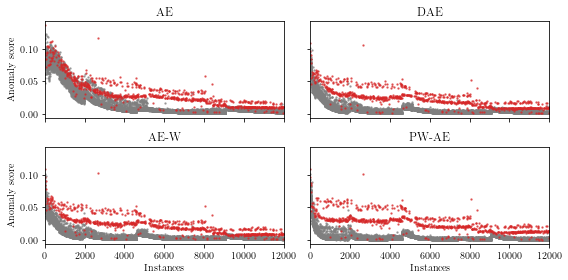

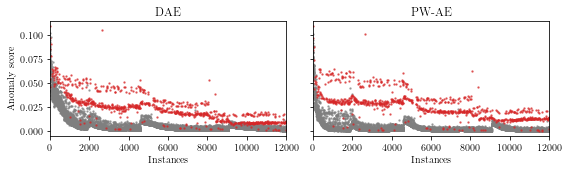

In [58]:
plot_score_comparison(["AE", "AE-W", "DAE", "PW-AE"], datasets={"shuttle": Shuttle}, stop=12000, nrows=2, sharey=True, file_prefix="aes_unscaled_", unscaled=True)
plot_score_comparison(["DAE", "PW-AE"], datasets={"shuttle": Shuttle}, stop=12000, nrows=1, sharey=True, file_prefix="dae_vs_pwae_unscaled_", unscaled=True, height=2.5)

### Make Score Comparison with Zoomed Window

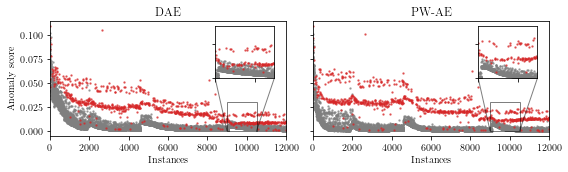

In [59]:
models=["DAE", "PW-AE"]  
nrows=1
ncols=2
width=8
height=2.5
alpha=0.6
start=0
stop=12000
zoom_start = 9000
zoom_end = 10500


fig, axs = plt.subplots(
    nrows=nrows, ncols=ncols, figsize=(width, height), sharex=True, sharey=True
)
labels = np.array([row[1] for row in Shuttle().take(stop)])

axs[0].set_xlim(start, stop)
axs[0].set_ylabel("Anomaly score")
axs[0].set_xlabel("Instances")
axs[1].set_xlabel("Instances")


scores_dae = np.load(f"../results/scores/DAE_shuttle_unscaled.npy")
scores_pwae = np.load(f"../results/scores/PW-AE_shuttle_unscaled.npy")

plot_scores(
    scores_dae[start:stop], labels[start:stop], ax=axs[0], model="DAE", alpha=alpha
)
plot_scores(
    scores_pwae[start:stop], labels[start:stop], ax=axs[1], model="PW-AE", alpha=alpha
)

axins = [ax.inset_axes([0.7, 0.50, 0.25, 0.45]) for ax in axs]

plot_scores(
    scores_dae[start:stop], labels[start:stop], ax=axins[0], model="", alpha=alpha
)
plot_scores(
    scores_pwae[start:stop], labels[start:stop], ax=axins[1], model="", alpha=alpha
)

for axin in axins: 
    axin.set_xlim(zoom_start, zoom_end)
    axin.set_ylim(0, 0.03)
    axin.set_xticklabels([])
    axin.set_yticklabels([])

axs[0].indicate_inset_zoom(axins[0], edgecolor="black")
axs[1].indicate_inset_zoom(axins[1], edgecolor="black")

plt.tight_layout()
plt.savefig(f"../results/figures/scores_dae_vs_pwae_unscaled_zoom_shuttle.pdf")

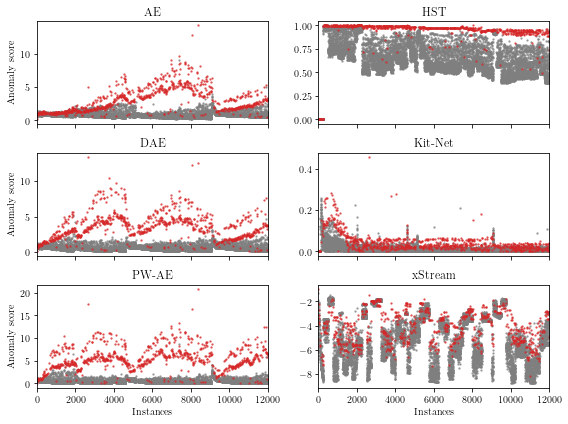

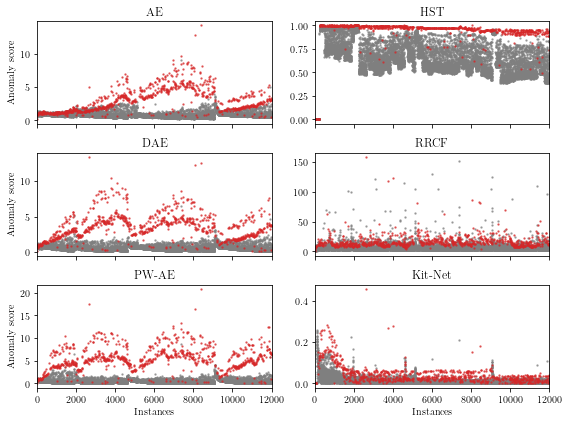

In [60]:
plot_score_comparison(models=["AE", "DAE", "PW-AE", "HST", "Kit-Net", "xStream"], datasets={"shuttle": Shuttle}, stop=12_000)
plot_score_comparison(["AE", "DAE", "PW-AE", "HST", "RRCF", "Kit-Net"], datasets={"shuttle": Shuttle}, file_prefix="models_w_rcf_", stop=12_000)

## Plot Learning Rate Results

In [61]:
lr_data = pd.read_csv(f"../results/Learning Rate.csv")
lr_data = lr_data.groupby(["optimizer_fn", "lr", "model"]).mean().reset_index()

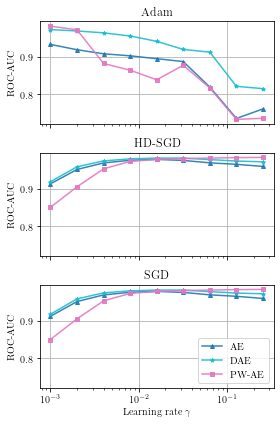

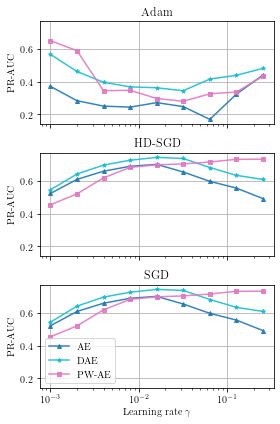

In [62]:
width = 4
height = 6
alpha = 0.9
for metric in ["ROC-AUC", "PR-AUC"]:
    fig, axs = plt.subplots(nrows=3, figsize=(width, height), sharex=True, sharey=True)

    for idx, (optim_name, optim_data) in enumerate(lr_data.groupby("optimizer_fn")):
        for model_name, model_data in optim_data.groupby("model"):
            axs[idx].plot(
                model_data["lr"],
                model_data[metric],
                label=model_name,
                c=colors[model_name],
                marker=markers[model_name],
                ms=4,
                alpha=alpha,
            )

        ax = axs[idx]
        ax.set_ylabel(metric)
        title = "Adam" if optim_name == "adam" else optim_name.upper()
        ax.set_title(title)
        ax.grid()

    axs[2].set_xscale("log")
    axs[2].set_xlabel(r"Learning rate $\gamma$")
    axs[2].legend()
    plt.tight_layout()
    plt.savefig(f"../results/figures/{metric.lower()}_vs_lr.pdf")